In [54]:
import pandas as pd
import numpy as np
import datetime
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import string
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data Source

We use tha data source outputed from the timeseries pre processing done in this notebook (https://www.kaggle.com/joaquinruisenor/timeseries-prophet). We input a univariate timeseries data of the power consumption of the PJME grid in the USA.

PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).
.

In [55]:
df_arima = pd.read_csv('Energy_PJM.csv')

In [56]:
df_arima.head()

,Datetime,Energy
0,2002-12-31 01:00:00,31575.0
1,2002-12-31 02:00:00,30086.0
2,2002-12-31 03:00:00,29459.0
3,2002-12-31 04:00:00,29250.0
4,2002-12-31 05:00:00,29790.0


# Arima Modelling

We can use ARIMA models when we know there is dependence between values and we can leverage that information to forecast. 

ARIMA = Auto-Regressive Integrated Moving Average.
Assumptions. The time-series is stationary.
Depends on:
1. Number of AR (Auto-Regressive) terms (p).
2. Number of I (Integrated or Difference) terms (d).
3. Number of MA (Moving Average) terms (q).

These parameters are estimated by observating ACF (autocorrelation function) and PACF (partial autocorrelation functions).

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lag.

We use tha PACF to evaluate the AR model, because it is built the correlation between timespots, this is why we use this function to build the "real correlation" between timespots. Only significant terms will be chosen.

We use the ACF autocorrelation to use in the MA model,

How do we interpret ACF and PACF plots?

- p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – Lag value where the ACF chart crosses the upper confidence interval for the first time.

Greater variation in the data, leads to a wider confidence interval. The effect of sampling error is reduced with larger samples.

From the past notebook (https://www.kaggle.com/joaquinruisenor/timeseries-prophet) we are using a stationary dataframe as input for this modeling.

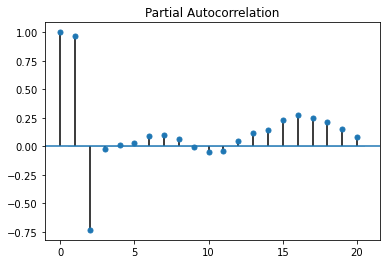

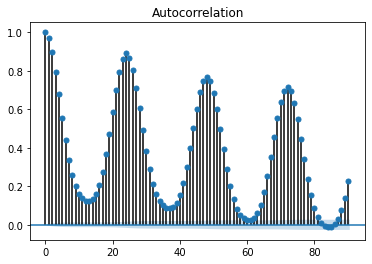

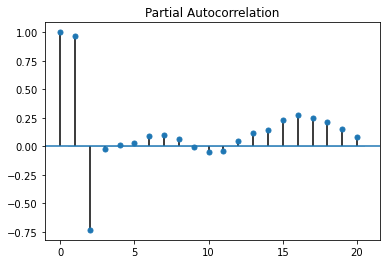

In [57]:
plot_acf(df_arima["Energy"],alpha=0.1, lags=90)
plot_pacf(df_arima["Energy"],alpha=0.1, lags=20)

We consider that values that surpasses the significance thresholds (in blue) are significant. In the PACF chart we can see many significant points. Looking at the ACF chart we have even more significant points making a tentative MA model even more complicated than AR model alone (due to the fact that it has many dependent variables). Both using an AR model or a MA model would imply using many dependent variables.

The reason we choose to use an ARIMA model is because we see many dependent variables both in the ACF functions and the PACF functions. One thing to keep in mind is that between combinations of p, d, q parameters we want to choose the model with fewer error terms.

One of the definitive conclusions we can take after looking at the above charts is that this dataset is definitely not random produced.

We create a function taken from 'https://colab.research.google.com/drive/1oBXX3k3OOjdivwlDhpLmAqfq5B5dzFR1#scrollTo=1a_2PefcYouT2' to create the arima model so that later we can insert different values of p,d and q

In [58]:
#We split the data into training and testing set
df_arima.set_index('Datetime', inplace = True) #make the index is out date time
split_date = '2017-01-01'
df_train = df_arima.loc[df_arima.index <= split_date].copy()
df_test = df_arima.loc[df_arima.index > split_date].copy()

In [59]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_train.head()

,Datetime,Energy
0,2002-12-31 01:00:00,31575.0
1,2002-12-31 02:00:00,30086.0
2,2002-12-31 03:00:00,29459.0
3,2002-12-31 04:00:00,29250.0
4,2002-12-31 05:00:00,29790.0


In [69]:
def run_arima_model(df, ts, p, d, q):
    
    from statsmodels.tsa.arima_model import ARIMA

    # fit ARIMA model on time series
    model = ARIMA(df[ts], order=(p, d, q))  
    results_ = model.fit(disp=-1)  
  
    # get lengths correct to calculate RSS
    len_results = len(results_.fittedvalues)
    ts_modified = df[ts][-len_results:]
  
    # calculate root mean square error (RMSE) and residual sum of squares (RSS)
    rss = sum((results_.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(df[ts]))
  
    # plot fit
    plt.plot(df[ts])
    plt.plot(results_.fittedvalues, color = 'red')
    plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
    plt.show()
    plt.close()
  
    return results_ 

In [61]:
df_modelo = df_arima.reset_index()
df_arima.head().append(df_arima.tail())

,Energy
Datetime,
2002-12-31 01:00:00,31575.0
2002-12-31 02:00:00,30086.0
2002-12-31 03:00:00,29459.0
2002-12-31 04:00:00,29250.0
2002-12-31 05:00:00,29790.0
2018-01-01 20:00:00,52685.0
2018-01-01 21:00:00,52124.0
2018-01-01 22:00:00,50640.0
2018-01-01 23:00:00,48122.0


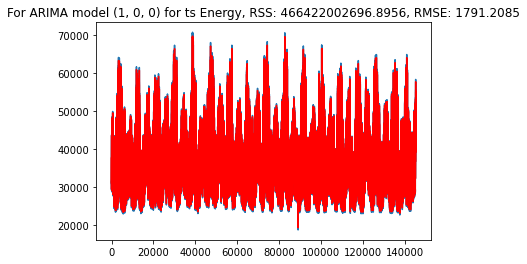

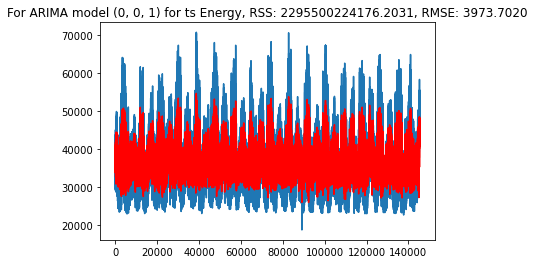

In [62]:
# AR model with 1st order differencing - ARIMA (1,0,0) or AR model
model_AR = run_arima_model(df = df_modelo,  
                           ts = 'Energy',
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1) or MA model
model_MA = run_arima_model(df = df_modelo, 
                           ts = 'Energy',
                           p = 0, 
                           d = 0, 
                           q = 1)


### Error Measuring

we already see a measure of the error on the superior part of each graph, but to be consistent with the prophet modelling we are going to calculate the error here.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

| Model          | RMSE         | 
| :------------- | :----------: |
|  AR            | 1971.2085    | 
|  MA            | 3973.7020    | 

## To do

1. Perform ARIMA modelling
2. Try to forecast only year 2017